## Prediction of chemical exchange observables from Markov models

Simon Olsson (email: simon.olsson@fu-berlin.de) - Jan 6th 2017
#### Preliminaries
With this Jupyter notebook I provide some minimal examples on how to compute some common NMR observables sensitive to chemical exchange. The aim is to help people who want to apply the methodology we recently presented in our manuscript "Mechanistic Models of Chemical Exchange Induced Relaxation in Protein NMR" (doi: 10.1021/jacs.6b09460). There are several observables which are _not_ covered - popular onces include CEST, HARD, MQ and solid-state observables. I will try to update this notebook with more examples in the future, as I find the time to do so. The medium-term goal is to make a stand-alone library for python which replaces this notebook, *feedback and contributions are therefore very welcome via. e-mail*. Until then I've designed this notebook in such a way that cells have well-defined functionality which can easily be copy-pasted into more advanced analysis workflows.

While I've tried to make this notebook as self-contained as possible, I've also aimed at making it concise. Do not expect a thorough introduction to Markov models here - I will only outline key topics relevant here. If you are new to MSMs I refer the following authoritative review: Prinz et al JCP 2011 (doi: 10.1063/1.3565032). If you are new to chemical exchange relaxation in NMR I refer to any recent review on the topic by fx Arthur G. Palmer III (fx doi: 10.1021/cr0404287) or D. Flemming Hansen (doi: 10.1007/978-1-4899-7621-5_3) (solution state) or Ernst and Schanda (fx. doi: 10.1016/j.pnmrs.2016.02.001) (solid state). For specific issues, further details may be found in the following manuscript:

Olsson and Noé "Mechanistic Models of Chemical Exchange Induced Relaxation in Protein NMR" In press JACS
http://pubs.acs.org/doi/abs/10.1021/jacs.6b09460

Alternatively, you can shoot me an email or message me on twitter @solnmr.

If you find this notebook helpful or use it in your research please consider citing this paper.

The notebook is written for Python 2.7 - but can trivially be converted to be Python 3.X compatible.

Dependencies: numpy, scipy, msmtools, matplotlib

### Chemical exchange in the fast-exchange limit - a quick primer
The chemical shift is an atomic resolution measure of the local chemical (structural) environment and its correlation function is sensitive to the fluctuations of this quantity over time. In the fast-exchange limit the exchange induced relaxation $R_2^{ex}$ is sensitive to the integral of chemical shift correlation function $g(\tau)$,
$$ R_2^{ex} = (2\pi \nu_0)^2 \int_0^{\infty} g(\tau)\;\mathrm{d}\tau.$$
$\nu_0$ is the Larmor frequency of the measured nucleus at the experimental conditions. A number of common NMR experiments either allow for measurement of this quantity or related quantities where a experimentally controlled convolution of the correlation function is measured.  These experiments therefore gives us information about the structure, thermodynamics and kinetics of a particular system, and provides a valuable avenue to validate Markov models built using imperfect molecular mechanics forcefields.
### Correlation functions of Markov models
Recall the the auto-correlation function - e.g. a chemical shift correlation function - of a transition probability matrix $\mathbf{P}$ at lag-time of $\Delta t$ and $M$ states is a mixture of $M-1$ exponetial decays
$$ g(\tau) = \sum_{i=2}^M c_i \exp(-\tau/\tau_i^{ex})$$
with
$$ c_i = (\mathbf{f}\cdot\mathbf{l}_i)^2, \hspace{0.1cm} \tau_i^{ex} = \frac{-\Delta t}{\log\mid \lambda_i \mid}$$
where $\mathbf{l}_i$ is the ith left eigenvector of $\mathbf{P}$ and $\lambda_i$ is the corresponding eigenvalue. $\mathbf{f}$ is the average microscopic observable in each of the $M$-microstates of $\mathbf{P}$. In the context of chemical exchange $\mathbf{f}$ is the chemical shift of each of the Markov model micro-states. In MSM jargon the pairs of $c_i, \tau^{ex}_i$ for a Markov model is often called a *fingerprint*.
### Some analytical expressions of observable exchange induced relaxation rates
Correlation functions of this form gives rise to tractable analytic experessions of observable exchange induced relaxation. The expression from above becomes:
$$ R_2^{ex} = (2\pi \nu_0)^2 \sum_{i=2}^M c_i\tau^{ex}_i. $$
Two other examples presented here are observed rates in CPMG (for details please the manuscript)
$$R_{1\rho,CPMG}^{\mathrm{ex}}(\nu_{\mathrm{CP}})=(2\pi\nu_{0})^{2}\left(\sum_{i=2}^{m}c_{i}\tau_{i}^{\mathrm{ex}}\left(1-\frac{{\tau_{i}^{\mathrm{{ex}}}}}{\tau_{\mathrm{{CP}}}}\tanh{\frac{\tau_{\mathrm{CP}}}{\tau_{i}^{\mathrm{ex}}}}\right)\right)$$
and spin-lock experiments
$$ R_{1\rho,SL}^{\mathrm{ex}}(\nu_{1})=(2\pi\nu_{0})^{2}\left(\sum_{i=2}^{m}c_{i}\frac{\tau_{i}^{\mathrm{ex}}}{1+(\tau_{i}^{\mathrm{ex}}\nu_{1})^{2}}\right).$$
$\nu_1$ is the spin-lock frequency and $\tau_{\text{CPMG}}$ is the inter-pulse delay in the CPMG pulse-train.



In [177]:
%pylab inline
import numpy as np
import msmtools as mt
import scipy as sp
from matplotlib import pyplot as plt
np.random.seed(303808) # set random seed for reproducibility

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Toy system
The following sets up a 3 state toy system with artificial chemical shifts.

First a reference model is defined, 100 trajectories of 50000 nanoseconds are generated. Corresponding 'chemical shift' trajectories are generated. 

### Practical considerations
In a real setting, _dtrajs_ will be your MD trajectories projected onto a discretized space (assigned to cluster centers), and _ftrajs_ will be the same MD trajectories where each index is a predicted chemical shift for the corresponding MD frame. This should be done prior to analysis using Camshift, ShiftX2 (w/o ShiftY option), PPM, SPARTA+, or another method. The function *cluster_averages* can then be used to compute the vector $\mathbf{f}$ needed for computation of the 'fingerprint'.

In [178]:
# Simple reversible three state Markov model - two wells and a barrier
T = np.array([[0.99, 0.01, 0.0], 
              [0.2, 0.1, 0.7], 
              [0.0, 0.002, 0.998]])

#Delta t = 5ns
Deltat = 5e-9

# State 'chemical shift' average and standard deviation
CSp = [[7.1, .9], [8.2, 0.15], [8.9, 0.43]] # all in p.p.m.

#generate 100 Trajectories of length 5microseconds using the Gillespie algorithm 
dtrajs = mt.generation.generate_trajs(T, 100, 10000)
#generate corresponding 'chemical shift' trajectories
ftrajs = [np.array([np.random.normal(CSp[frame][0], CSp[frame][1]) for frame in dt]) for dt in dtrajs]

In [179]:
mt.analysis.statdist(T)

array([ 0.05390836,  0.00269542,  0.94339623])

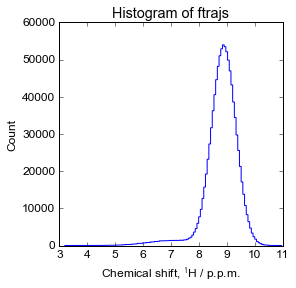

In [180]:
import matplotlib
font = {
        #font.sans-serif     : Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif
       'size'   : 12}
matplotlib.rcParams['font.family'] = 'Arial'

matplotlib.rc('font', **font)
matplotlib.rcParams['mathtext.fontset'] = 'stixsans'
matplotlib.rcParams['font.sans-serif'] = 'Arial'

f, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))
ax.hist(np.hstack(ftrajs), bins = 128, histtype='step', log=False)
ax.set_xlabel(r'Chemical shift, $^1$H / p.p.m.')
ax.set_ylabel(r'Count')
ax.set_title('Histogram of ftrajs')


In [181]:
# Estimate Markov model from synthetic data
countmatrix_synthetic_data = mt.estimation.count_matrix(dtrajs, 1)
T_synthetic = mt.estimation.tmatrix(countmatrix_synthetic_data, reversible=True)

In [182]:
# Function to compute microstate observables from an aligned set of dtrajs and ftrajs
def cluster_averages(dtrajs, ftrajs, n_clusters):
    """
    dtrajs - list of np.arrays (N,)
    ftrajs - list of np.arrays (N,A)
    n_clusters - int (number of states in dtrajs) 

    returns cluster averages as list shape(n_clusters, A)
    """
    c_avgs = [[] for i in range(n_clusters)]
    for dt,ft in zip(dtrajs,ftrajs):
        for i in range(n_clusters):
            c_avgs[i].append( ft[dt == i] )
    return map(lambda x:np.hstack(x).mean(axis=0), c_avgs)


In [183]:
# Compute f-vector
microscopic_cs = cluster_averages(dtrajs, ftrajs, 3)

### Computing fingerprints using msmtools
From above we have the two quantities needed to compute the 'fingerprints'. From the fingerprints we can then evaluate the expressions of the observables as needed.

In [184]:
fingerprints = mt.analysis.fingerprint_correlation(T, microscopic_cs, tau=Deltat)

In [185]:
def r1rho_pure(fp, nu, nums=[0,1]):
    """
    Compute exchange contribution to r1rho spin-lock relaxation rate.
    arguments:
    fp - fingerprints
    nu - np.array of spin-lock frequencies
    nums - iterable of integers, indicies of process to include
    
    returns np.array of induced relaxation rates (same shape as nu)
    """
    times = fp[0][1:]
    coefs = fp[1][1:]
    return np.sum([coefs[i]*times[i]/(1+(times[i]*nu)**2.) for i in nums], axis=0)

def cpmg_pure(fp, taucpmg, nums=[0,1]):
    """
    Compute exchange contribution to CPMG relaxation rate.
    arguments:
    fp - fingerprints
    taucpmg - np.array of CPMG frequencies (1/\tau_CPMG)
    nums - iterable of integers, indicies of process to include
    
    returns np.array of induced relaxation rates (same shape as nu)
    """    
    times = fp[0][1:]
    coefs = fp[1][1:]
    return np.sum([coefs[i]*times[i]*(1-times[i]/taucpmg*np.tanh(taucpmg/times[i]) ) for i in nums], axis=0)

def rex_pure(fp, nums=[0,1]):
    """
    Compute exchange contribution to CPMG relaxation rate.
    arguments:
    fp - fingerprints
    nums - iterable of integers, indicies of process to include
    
    returns np.array of induced relaxation rates (same shape as nu)
    """    
    times = fp[0][1:]
    coefs = fp[1][1:]
    return np.sum([coefs[i]*times[i] for i in nums], axis=0)

## Examples
A quick note on units. The final units are always $s^{-1}$. $\nu_0$ is expressed as $s^{-1}\,\text{ppm}^{-1}$ since the output of $R_2(\cdot)$ (any of the observable calculations) is $s\,\text{ppm}^2$. Fx. the prefactor $(2\pi\nu_0)^2$ for a $^1$H nucleus at 800MHz will be $(2\pi 800\cdot10^6\,\text{Hz}\, \text{ppm}^{-1})^2 = (2\pi\, 800)^2 $ with units $s^{-2}\,\text{ppm}^{-2}$. Multiplied by an observable function: $s^{-2}\,\text{ppm}^{-2} s\,\text{ppm}^{2} = s^{-1}$

### 1. Chemical exchange contribution

In [186]:
print "Rex is for this 1H proton is %.3f s^-1 at 800MHz"%((2*np.pi*800)**2.*rex_pure(fingerprints))

Rex is for this 1H proton is 2.561 s^-1 at 800MHz


### 2. $R_{1\rho,SL}$

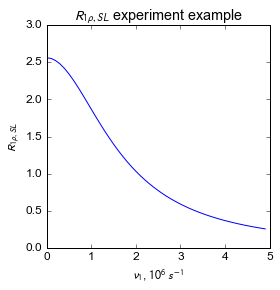

In [187]:
nu = np.arange(1e3,5e6,1e5)
f, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))
ax.plot(nu/1e6, (2*np.pi*800)**2.*r1rho_pure(fingerprints,nu,nums=[0,1] ))

ax.set_xlabel(r'$\nu_1$, $10^6\; s^{-1}$')
ax.set_ylabel(r'$R_{1\rho,SL}$')
ax.set_title(r'$R_{1\rho,SL}$ experiment example')


### 3. $R_{1\rho,CPMG}$

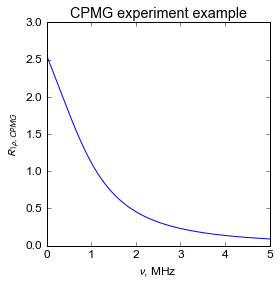

In [188]:
taucpmg = 1./np.linspace(1e3,5e6,8000)
f, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))
ax.plot(1e-6/(taucpmg), (2*np.pi*800.)**2.*cpmg_pure(fingerprints, taucpmg, nums=[0,1]))

ax.set_xlabel(r'$\nu$, MHz')
ax.set_ylabel(r'$R_{1\rho,CPMG}$')
ax.set_title(r'CPMG experiment example')


### 4. Partial relaxation dispersion
That is, when a difference experiment is carried out. For example: $\Delta R_2 = R_{1\rho,CPMG}(2\,\text{MHz}) - R_{1\rho,CPMG}(0.1\,\text{MHz})$ 

In [189]:
print "Delta R_2 at 800MHz, %.3f s^-1"%((2*np.pi*800.)**2.*(cpmg_pure(fingerprints, [2e-6], nums=[0,1])-cpmg_pure(fingerprints, [0.1e-6], nums=[0,1]) )[0])

Delta R_2 at 800MHz, 1.764 s^-1


### 5. _Ad hoc_ compensation for auxillary relaxation effects and insufficient chemical shift amplitudes
Many relaxation dispersion measurements will be 'tainted' by other relaxation effects ($R_{2,intrinsic}$). In addition, many chemical shift prediction algorithms appear to underestimate the chemical shift amplitudes ('variances'), which results in systematic underestimation of the amplitudes. One way to overcome this is to fit these parameters in a linear fit:
$$ R_{2,obs} = R_{2,intrinsic} + \alpha R_2$$
where $\alpha$ is a unitless amplitude correction.

First we generate a synthetic dataset with noise ($0.45\,\text{Hz}$), $\alpha$ ($23$), $R_{2,intrinsic}$ ($12.1\,\text{Hz} $)

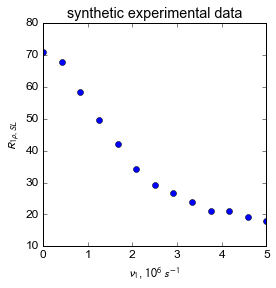

In [190]:
# generate synthetic experimental data with Gaussian noise (0.45 Hz)
r2_intrinsic = 12.1 # Hz
alpha = 2.3e1 # a.u.
nu_exp  = np.linspace(1e3,5e6,13) # Hz
R2_slexp = alpha*(2*np.pi*800)**2.*r1rho_pure(fingerprints,nu_exp,nums=[0,1] )+r2_intrinsic + np.random.normal(0, 0.45, size=np.shape(nu_exp))
f, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))
ax.plot(nu_exp/1e6, R2_slexp,'o')

ax.set_xlabel(r'$\nu_1$, $10^6\; s^{-1}$')
ax.set_ylabel(r'$R_{1\rho,SL}$')
ax.set_title(r'synthetic experimental data')


Imports and helper function for fitting unknown parameters (simple least-squares)

In [191]:
from scipy.optimize import curve_fit

def fitfunc(x, a, b):
    return abs(a) * x + abs(b)  

Fit, predict and plot:

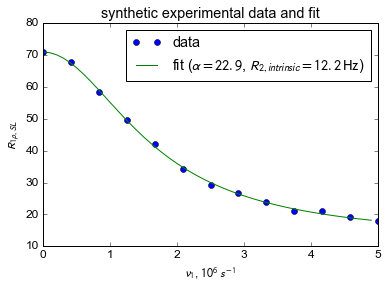

In [192]:
#fit
pv, pcov = curve_fit(fitfunc, (2*np.pi*800)**2.*r1rho_pure(fingerprints, nu_exp, nums=[0,1]), R2_slexp)
#predict
prediction = pv[0]*(2*np.pi*800)**2.*r1rho_pure(fingerprints, np.arange(1e3,5e6,1e5),nums=[0,1])+pv[1]

#plot
f, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4))
ax.plot(nu_exp/1e6, R2_slexp,'o', label='data')
ax.plot(np.arange(1e3,5e6,1e5)/1e6, prediction, label=r'fit ($\alpha=%.1f$, $R_{2,intrinsic}=%.1f\,\mathrm{Hz}$)'%(pv[0], pv[1]))
ax.set_xlabel(r'$\nu_1$, $10^6\; s^{-1}$')
ax.set_ylabel(r'$R_{1\rho,SL}$')
ax.legend()
ax.set_title(r'synthetic experimental data and fit')
